clang-13: error: the clang compiler does not support '-march=native'
WARNING    Cannot use Cython, a test compilation failed: command '/Users/minsu/miniforge3/envs/bmnn2/bin/arm64-apple-darwin20.0.0-clang' failed with exit code 1 (CompileError) [brian2.codegen.runtime.cython_rt.cython_rt.failed_compile_test]
INFO       Cannot use compiled code, falling back to the numpy code generation target. Note that this will likely be slower than using compiled code. Set the code generation to numpy manually to avoid this message:
prefs.codegen.target = "numpy" [brian2.devices.device.codegen_fallback]


Starting simulation at t=0. s for a duration of 0.6 s
80.8 ms (13%) simulated in 10s, estimated 1m 5s remaining.
146.4 ms (24%) simulated in 20s, estimated 1m 3s remaining.
212. ms (35%) simulated in 30s, estimated 56s remaining.
277.6 ms (46%) simulated in 40s, estimated 47s remaining.
0.3432 s (57%) simulated in 50s, estimated 38s remaining.
0.4088 s (68%) simulated in 1m 0s, estimated 29s remaining.
0.4729 s (78%) simulated in 1m 10s, estimated 19s remaining.
0.5384 s (89%) simulated in 1m 21s, estimated 9s remaining.
0.6 s (100%) simulated in 1m 30s
Starting simulation at t=0. s for a duration of 1.2 s
213. ms (17%) simulated in 10s, estimated 46s remaining.
0.4231 s (35%) simulated in 20s, estimated 37s remaining.
0.6337 s (52%) simulated in 30s, estimated 27s remaining.
0.8496 s (70%) simulated in 40s, estimated 17s remaining.
1.0663 s (88%) simulated in 50s, estimated 6s remaining.
1.2 s (100%) simulated in 56s
Starting simulation at t=0. s for a duration of 1.2 s
295. ms (24%) 

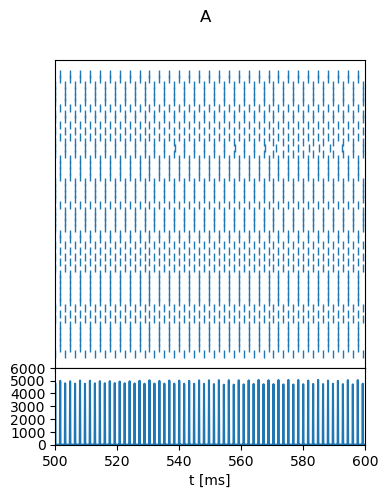

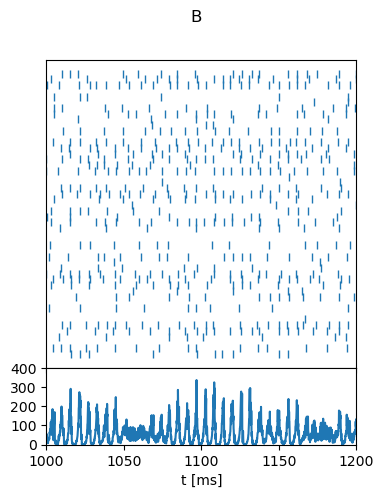

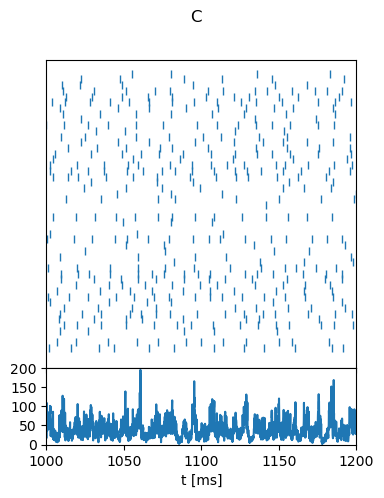

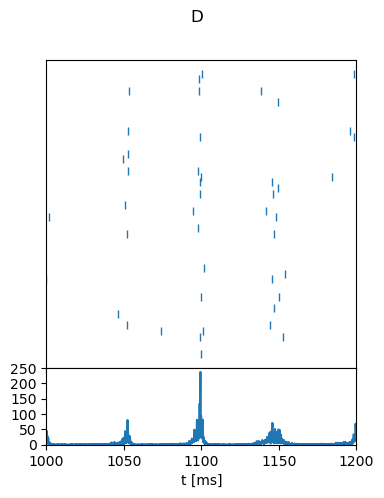

In [1]:
import random
from brian2 import *
import matplotlib.pyplot as plt


def sim(g, nu_ext_over_nu_thr, sim_time, ax_spikes, ax_rates, rate_tick_step):
    """
    g -- relative inhibitory to excitatory synaptic strength
    nu_ext_over_nu_thr -- ratio of external stimulus rate to threshold rate
    sim_time -- simulation time
    ax_spikes -- matplotlib axes to plot spikes on
    ax_rates -- matplotlib axes to plot rates on
    rate_tick_step -- step size for rate axis ticks
    """

    # network parameters
    N_E = 10000
    gamma = 0.25
    N_I = round(gamma * N_E)
    N = N_E + N_I
    epsilon = 0.1
    C_E = epsilon * N_E
    C_ext = C_E

    # neuron parameters
    tau = 20 * ms
    theta = 20 * mV
    V_r = 10 * mV
    tau_rp = 2 * ms

    # synapse parameters
    J = 0.1 * mV
    D = 1.5 * ms

    # external stimulus
    nu_thr = theta / (J * C_E * tau)

    defaultclock.dt = 0.1 * ms

    neurons = NeuronGroup(N,
                          """
                          dv/dt = -v/tau : volt (unless refractory)
                          """,
                          threshold="v > theta",
                          reset="v = V_r",
                          refractory=tau_rp,
                          method="exact",
    )

    excitatory_neurons = neurons[:N_E]
    inhibitory_neurons = neurons[N_E:]

    exc_synapses = Synapses(excitatory_neurons, target=neurons, on_pre="v += J", delay=D)
    exc_synapses.connect(p=epsilon)

    inhib_synapses = Synapses(inhibitory_neurons, target=neurons, on_pre="v += -g*J", delay=D)
    inhib_synapses.connect(p=epsilon)

    nu_ext = nu_ext_over_nu_thr * nu_thr

    external_poisson_input = PoissonInput(
        target=neurons, target_var="v", N=C_ext, rate=nu_ext, weight=J
    )

    rate_monitor = PopulationRateMonitor(neurons)

    # record from the first 50 excitatory neurons
    spike_monitor = SpikeMonitor(neurons[:50])

    run(sim_time, report='text')

    ax_spikes.plot(spike_monitor.t / ms, spike_monitor.i, "|")
    ax_rates.plot(rate_monitor.t / ms, rate_monitor.rate / Hz)

    ax_spikes.set_yticks([])

    ax_spikes.set_xlim(*params["t_range"])
    ax_rates.set_xlim(*params["t_range"])

    ax_rates.set_ylim(*params["rate_range"])
    ax_rates.set_xlabel("t [ms]")

    ax_rates.set_yticks(
        np.arange(
            params["rate_range"][0], params["rate_range"][1] + rate_tick_step, rate_tick_step
        )
    )

    plt.subplots_adjust(hspace=0)


parameters = {
    "A": {
        "g": 3,
        "nu_ext_over_nu_thr": 2,
        "t_range": [500, 600],
        "rate_range": [0, 6000],
        "rate_tick_step": 1000,
    },
    "B": {
        "g": 6,
        "nu_ext_over_nu_thr": 4,
        "t_range": [1000, 1200],
        "rate_range": [0, 400],
        "rate_tick_step": 100,
    },
    "C": {
        "g": 5,
        "nu_ext_over_nu_thr": 2,
        "t_range": [1000, 1200],
        "rate_range": [0, 200],
        "rate_tick_step": 50,
    },
    "D": {
        "g": 4.5,
        "nu_ext_over_nu_thr": 0.9,
        "t_range": [1000, 1200],
        "rate_range": [0, 250],
        "rate_tick_step": 50,
    },
}

for panel, params in parameters.items():

    fig = plt.figure(figsize=(4, 5))
    fig.suptitle(panel)

    gs = fig.add_gridspec(ncols=1, nrows=2, height_ratios=[4, 1])

    ax_spikes, ax_rates = gs.subplots(sharex="col")

    sim(
        params["g"],
        params["nu_ext_over_nu_thr"],
        params["t_range"][1] * ms,
        ax_spikes,
        ax_rates,
        params["rate_tick_step"],
    )

plt.show()